<a href="https://colab.research.google.com/github/Skkkiiideeee/constructionsitesafetydetection/blob/main/constructionsitesafetydetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 861.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, shutil, cv2, random
warnings.filterwarnings('ignore')
from ultralytics import YOLO
from tqdm.notebook import tqdm
from collections import Counter, defaultdict

In [50]:
import kagglehub

# Download latest version
BASE_DIR = kagglehub.dataset_download("snehilsanyal/construction-site-safety-image-dataset-roboflow")
BASE_DIR= "/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data"
print("Path to dataset files:", BASE_DIR)

Path to dataset files: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data


In [51]:
OUTPUT_DIR = '/kaggle/working/yolo_dataset'
IMAGES_DIR = os.path.join(OUTPUT_DIR,'images')
LABELS_DIR = os.path.join(OUTPUT_DIR,'labels')

In [52]:
for split in ['train','val','test']:
    os.makedirs(os.path.join(IMAGES_DIR,split),exist_ok=True)
    os.makedirs(os.path.join(LABELS_DIR,split),exist_ok=True)

In [53]:
for split in ['train', 'valid', 'test']:
    split_new = 'val' if split == 'valid' else split
    img_dir = os.path.join(BASE_DIR, split, 'images')
    lbl_dir = os.path.join(BASE_DIR, split, 'labels')

    for fname in tqdm(os.listdir(img_dir)):
        if fname.endswith(".jpg"):
            # Copy image
            shutil.copy2(os.path.join(img_dir, fname), os.path.join(IMAGES_DIR, split_new, fname))
            # Copy label
            label_name = fname.replace(".jpg", ".txt")
            shutil.copy2(os.path.join(lbl_dir, label_name), os.path.join(LABELS_DIR, split_new, label_name))

  0%|          | 0/2605 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

In [54]:
def visualize_sample(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id, x_center, y_center, width, height = map(float, parts)
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(image, str(int(class_id)), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    plt.figure(figsize=(10,6))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

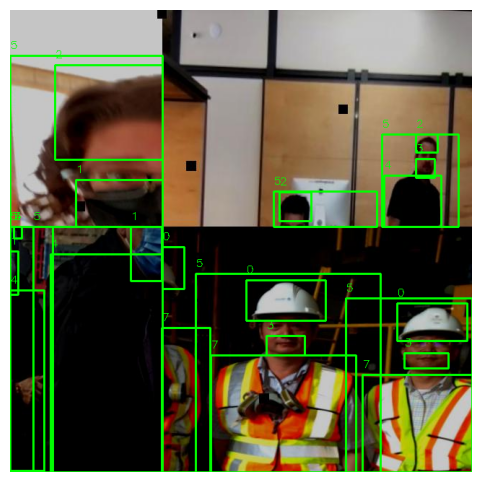

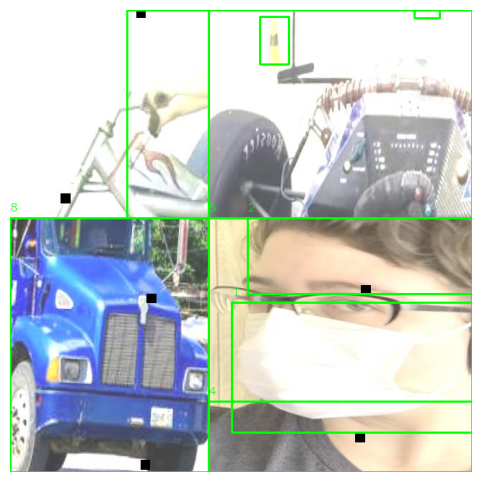

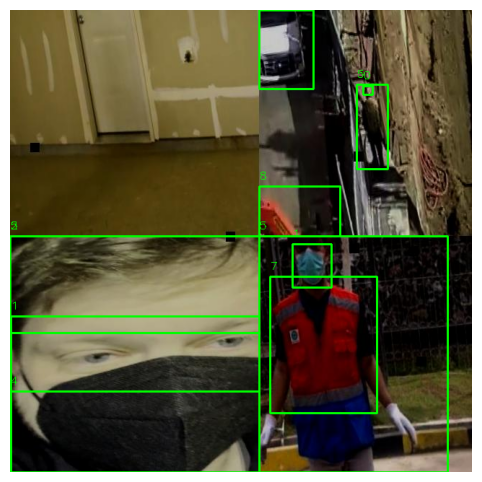

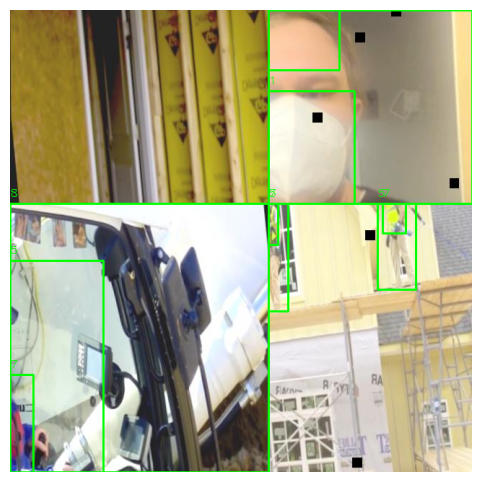

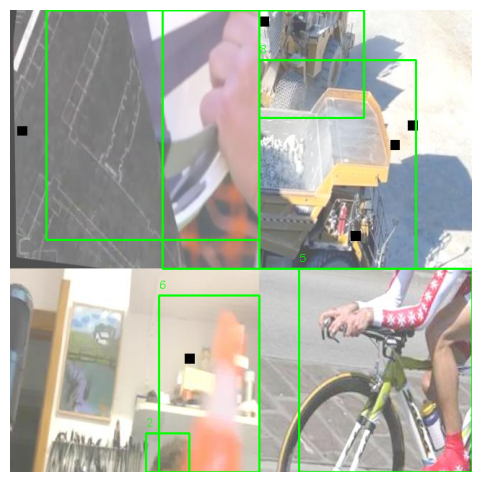

In [55]:
for _ in range(5):
    sample_img = os.path.join(IMAGES_DIR, 'train', random.choice(os.listdir(os.path.join(IMAGES_DIR, 'train'))))
    sample_lbl = sample_img.replace('images', 'labels').replace('.jpg', '.txt')
    visualize_sample(sample_img, sample_lbl)

In [56]:
# Write data.yaml file
with open(os.path.join(OUTPUT_DIR, "data.yaml"), "w") as f:
    f.write(f"""
    train: {IMAGES_DIR}/train
    val: {IMAGES_DIR}/val

    nc: 10
    names: ["Hardhat","Mask","NO-Hardhat","NO-Mask","NO-Safety Vest","Person","Safety Cone","Safety Vest","machinery","vehicle"]
    """)

In [57]:
# Load model
model = YOLO('yolov8n.yaml')

In [59]:
# Train model
model.train(
    data=os.path.join(OUTPUT_DIR,'data.yaml'),
    epochs=150,
    imgsz=640,
    batch=32,
    project=OUTPUT_DIR,
    name="construction_site_safety_detection_model",
    verbose=True
)

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=construction_site_safety_detection_model4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pe

train: Scanning /kaggle/working/yolo_dataset/labels/train.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /kaggle/working/yolo_dataset/images/train/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.7±1.5 ms, read: 379.9±53.9 MB/s, size: 52.1 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/yolo_dataset/construction_site_safety_detection_model4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/yolo_dataset/construction_site_safety_detection_model4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      6.09G      3.436      4.411       4.14        373        640: 100%|██████████| 82/82 [00:47<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        114        697   0.000257      0.046   0.000236    6.4e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      6.09G      3.008      3.793       3.49        278        640: 100%|██████████| 82/82 [00:44<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]

                   all        114        697    0.00193      0.129    0.00185   0.000459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      6.09G      2.373      3.347       2.81        282        640: 100%|██████████| 82/82 [00:45<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all        114        697      0.512      0.041    0.00441    0.00139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      6.11G      1.978      3.038      2.422        293        640: 100%|██████████| 82/82 [00:46<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all        114        697      0.515     0.0492     0.0129     0.0037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      6.11G      1.804      2.866       2.24        217        640: 100%|██████████| 82/82 [00:44<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

                   all        114        697      0.326     0.0701     0.0237      0.008



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      6.11G      1.716       2.76      2.135        303        640: 100%|██████████| 82/82 [00:44<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        114        697      0.533     0.0713     0.0363     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      6.65G      1.659      2.677      2.069        308        640: 100%|██████████| 82/82 [00:44<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all        114        697      0.402      0.108     0.0471     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      6.65G      1.618      2.611      2.017        247        640: 100%|██████████| 82/82 [00:46<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all        114        697      0.235      0.111      0.062     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      6.65G      1.598      2.558      1.989        268        640: 100%|██████████| 82/82 [00:45<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        114        697      0.307      0.153     0.0778      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      6.66G       1.56      2.501      1.948        237        640: 100%|██████████| 82/82 [00:45<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all        114        697      0.364      0.167       0.13     0.0419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      7.22G      1.551      2.468       1.93        183        640: 100%|██████████| 82/82 [00:45<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        114        697       0.39       0.16      0.134     0.0421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      7.22G      1.524      2.425      1.909        203        640: 100%|██████████| 82/82 [00:47<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        114        697      0.376      0.199      0.152     0.0571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      7.22G       1.51      2.375      1.883        328        640: 100%|██████████| 82/82 [00:44<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        114        697      0.501      0.191      0.178     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      7.82G        1.5      2.364      1.866        299        640: 100%|██████████| 82/82 [00:44<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all        114        697      0.403      0.207      0.173     0.0664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      5.27G       1.48      2.315      1.845        280        640: 100%|██████████| 82/82 [00:44<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

                   all        114        697      0.249      0.199       0.17     0.0686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      5.81G      1.472      2.291      1.835        333        640: 100%|██████████| 82/82 [00:44<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        697      0.496      0.229      0.222     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      5.81G      1.454      2.263      1.821        311        640: 100%|██████████| 82/82 [00:46<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        697      0.419      0.264      0.233     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      7.06G      1.448      2.236      1.811        292        640: 100%|██████████| 82/82 [00:44<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all        114        697       0.49      0.283      0.272      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      7.06G      1.447        2.2      1.797        214        640: 100%|██████████| 82/82 [00:45<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        114        697      0.456      0.285       0.28      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      7.06G      1.426      2.186      1.782        243        640: 100%|██████████| 82/82 [00:44<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        697      0.442      0.253      0.246     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      7.06G      1.426      2.153      1.773        299        640: 100%|██████████| 82/82 [00:45<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        114        697      0.472      0.306      0.294      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      7.06G        1.4      2.107      1.754        209        640: 100%|██████████| 82/82 [00:44<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

                   all        114        697      0.457      0.263      0.261       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      7.06G      1.409      2.096      1.753        267        640: 100%|██████████| 82/82 [00:44<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        114        697      0.461      0.322      0.306      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      7.08G      1.399      2.083      1.741        231        640: 100%|██████████| 82/82 [00:45<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        114        697      0.479      0.326      0.307      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      7.08G      1.396      2.058      1.732        230        640: 100%|██████████| 82/82 [00:44<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all        114        697      0.501      0.318      0.324      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      7.08G      1.396      2.032      1.732        248        640: 100%|██████████| 82/82 [00:49<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        114        697      0.546      0.337      0.347      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      7.09G      1.383      2.026      1.718        379        640: 100%|██████████| 82/82 [00:44<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        114        697       0.49      0.325      0.313      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      7.09G      1.374      1.992      1.711        267        640: 100%|██████████| 82/82 [00:45<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        114        697       0.51      0.332      0.335      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      7.09G      1.372      1.996       1.71        293        640: 100%|██████████| 82/82 [00:45<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]

                   all        114        697      0.496      0.346      0.349       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      7.11G      1.362      1.957      1.696        345        640: 100%|██████████| 82/82 [00:46<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        697      0.588      0.348      0.372      0.154


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      7.11G        1.4      1.946      1.734        171        640: 100%|██████████| 82/82 [00:47<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        114        697      0.528      0.378      0.366       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      7.11G      1.396      1.907      1.725        136        640: 100%|██████████| 82/82 [00:41<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all        114        697       0.58      0.365      0.392      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      7.13G      1.383       1.88      1.714        172        640: 100%|██████████| 82/82 [00:41<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        114        697      0.573      0.348      0.369      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      7.13G      1.383      1.861      1.707        184        640: 100%|██████████| 82/82 [00:43<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        114        697      0.574      0.397      0.406      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      7.13G      1.369       1.84      1.698        130        640: 100%|██████████| 82/82 [00:42<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        697      0.583      0.371        0.4      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      7.14G      1.363      1.822      1.688        179        640: 100%|██████████| 82/82 [00:43<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        114        697      0.629      0.359      0.405      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      7.14G      1.359        1.8      1.681        167        640: 100%|██████████| 82/82 [00:42<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        114        697      0.585      0.401      0.415      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      7.14G      1.353      1.793      1.678        151        640: 100%|██████████| 82/82 [00:42<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        697       0.63      0.402      0.433      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      7.14G      1.351      1.779       1.67        185        640: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        114        697      0.612      0.407      0.432      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      7.14G      1.344      1.768      1.666        133        640: 100%|██████████| 82/82 [00:41<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        697      0.621      0.414      0.436      0.198



40 epochs completed in 0.525 hours.
Optimizer stripped from /kaggle/working/yolo_dataset/construction_site_safety_detection_model4/weights/last.pt, 6.3MB
Optimizer stripped from /kaggle/working/yolo_dataset/construction_site_safety_detection_model4/weights/best.pt, 6.3MB

Validating /kaggle/working/yolo_dataset/construction_site_safety_detection_model4/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


                   all        114        697      0.613      0.415      0.437      0.199
               Hardhat         42         79      0.648      0.481      0.539      0.288
                  Mask         19         21      0.804      0.762      0.759       0.34
            NO-Hardhat         37         69      0.699      0.336      0.407      0.137
               NO-Mask         44         74      0.463      0.243      0.225      0.085
        NO-Safety Vest         56        106      0.601      0.255       0.32      0.143
                Person         84        166      0.598      0.428      0.452        0.2
           Safety Cone         13         44      0.585        0.5      0.545      0.255
           Safety Vest         28         41      0.739      0.488      0.553      0.281
             machinery         26         55      0.376      0.473      0.353      0.158
               vehicle         16         42      0.614      0.189      0.215     0.0997
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79920c8d3650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0


image 1/1 /kaggle/working/yolo_dataset/images/test/class2_131_jpg.rf.ad8314a9273471f1280ce8789ea75376.jpg: 640x640 1 machinery, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


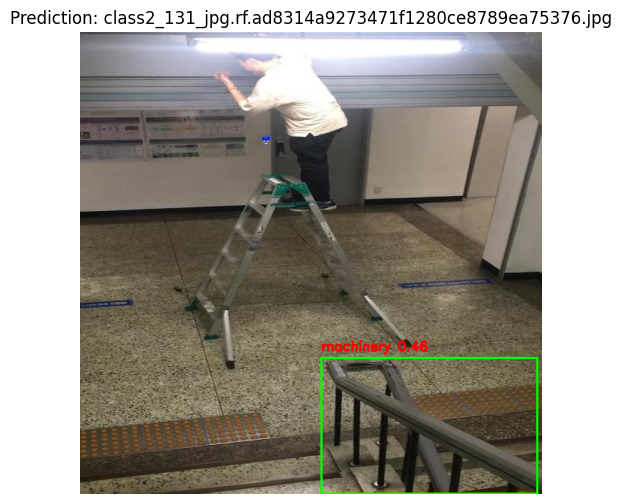


image 1/1 /kaggle/working/yolo_dataset/images/test/2009_000059_jpg.rf.50e8398a37eb33f33fd9f662feeea083.jpg: 640x640 1 NO-Hardhat, 3 NO-Masks, 1 Person, 14.5ms
Speed: 2.8ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


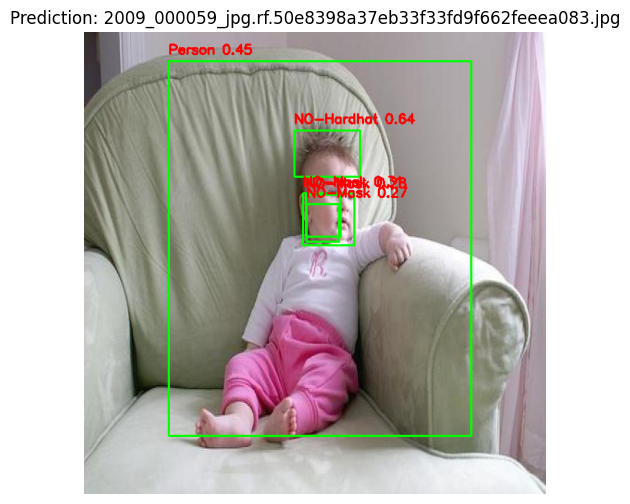


image 1/1 /kaggle/working/yolo_dataset/images/test/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 1 Person, 12.1ms
Speed: 3.9ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


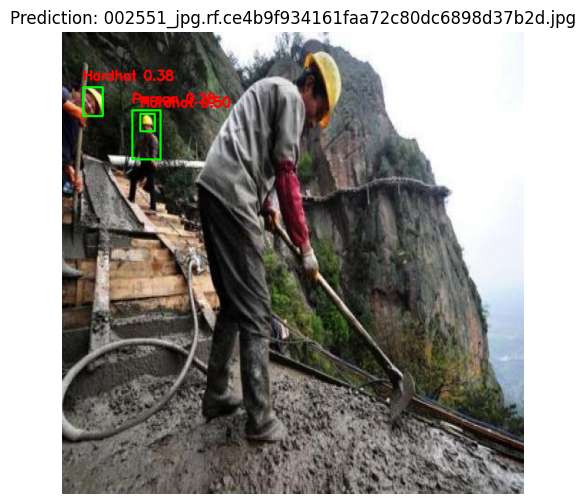


image 1/1 /kaggle/working/yolo_dataset/images/test/thumbnail-ba5c72edb320b49a69e86b05775c49b2-scaled-1_jpeg_jpg.rf.3bb460e284098219861b894fb0db13d5.jpg: 640x640 2 Hardhats, 1 Mask, 4 NO-Hardhats, 1 NO-Mask, 2 NO-Safety Vests, 4 Persons, 11.6ms
Speed: 3.0ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


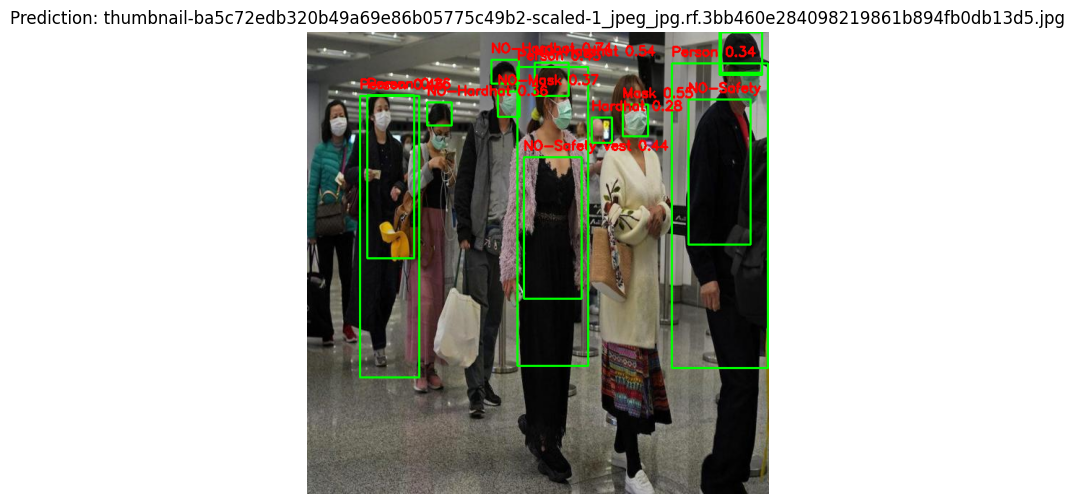


image 1/1 /kaggle/working/yolo_dataset/images/test/IMG_0871_MOV-12_jpg.rf.36858a9d51613f9a39b7855b54dfa098.jpg: 640x640 1 Mask, 1 NO-Hardhat, 1 NO-Safety Vest, 1 Person, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


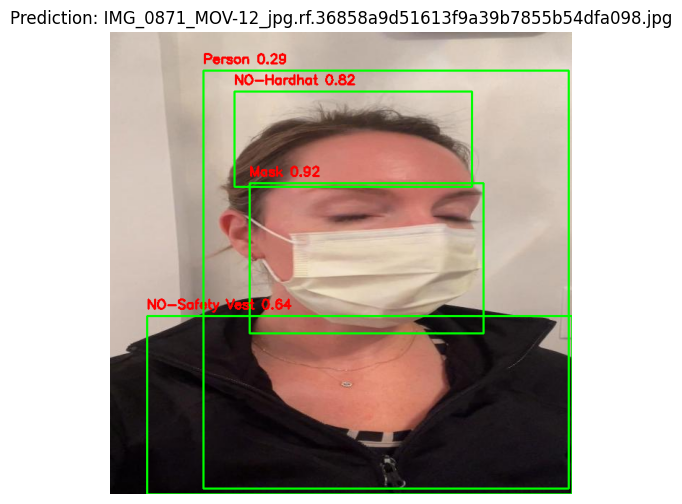


image 1/1 /kaggle/working/yolo_dataset/images/test/construction-275-_jpg.rf.e1c57987f9dc262aad1d7c67b694fd87.jpg: 640x640 (no detections), 15.5ms
Speed: 3.0ms preprocess, 15.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


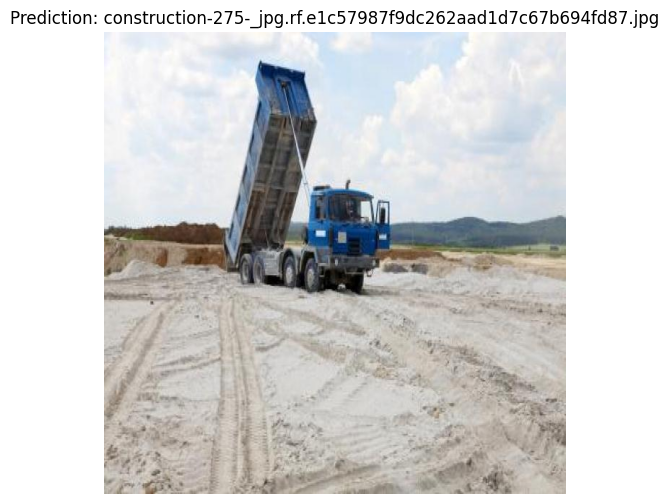


image 1/1 /kaggle/working/yolo_dataset/images/test/youtube-631_jpg.rf.7c6ecf859c1b0a659f8ea057ad27aebd.jpg: 640x640 2 Persons, 2 Safety Vests, 11.6ms
Speed: 3.1ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


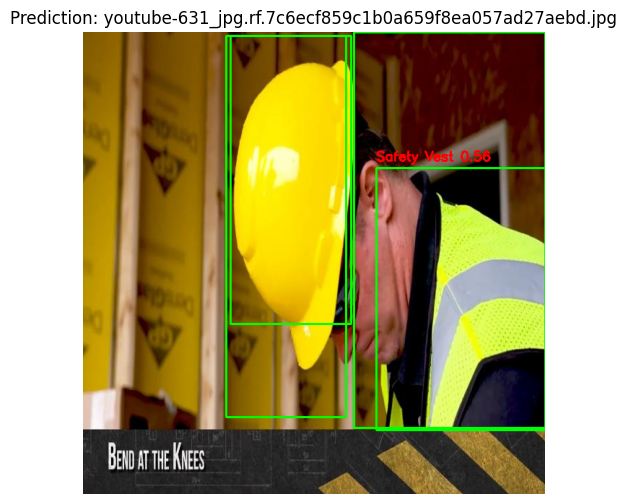


image 1/1 /kaggle/working/yolo_dataset/images/test/construction-275-_jpg.rf.e1c57987f9dc262aad1d7c67b694fd87.jpg: 640x640 (no detections), 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


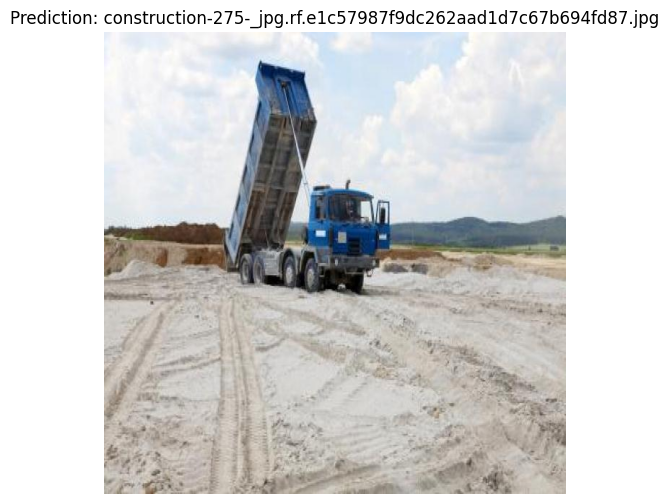


image 1/1 /kaggle/working/yolo_dataset/images/test/youtube-472_jpg.rf.e9425ff40c0df2beeef70abbc2324956.jpg: 640x640 1 Safety Vest, 15.8ms
Speed: 2.7ms preprocess, 15.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


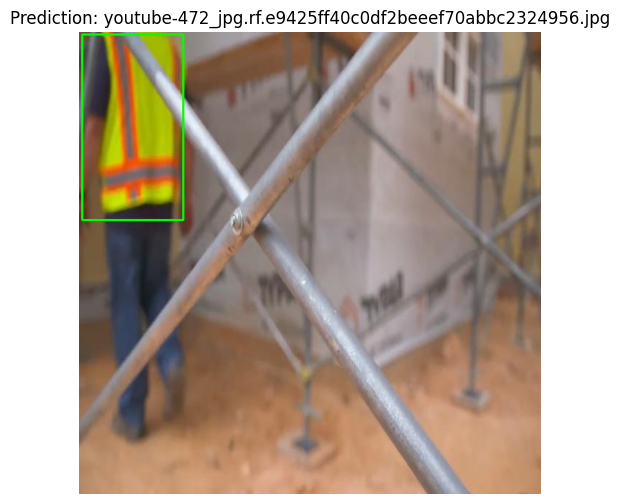


image 1/1 /kaggle/working/yolo_dataset/images/test/youtube-388_jpg.rf.18caa1da4f818a65f73e48463cb2270e.jpg: 640x640 2 machinerys, 11.5ms
Speed: 3.2ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


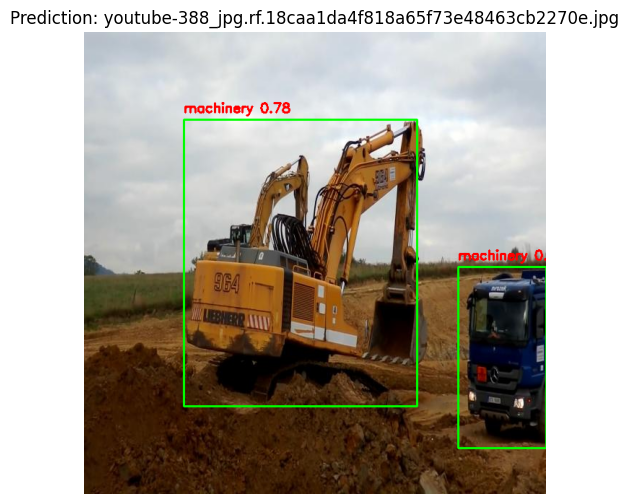

In [60]:
# Path to test images
test_dir = os.path.join(OUTPUT_DIR,'images','test')
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Store class counts and confidence scores
class_counter = Counter()
confidence_scores = defaultdict(list)

# Load class names from model
class_names = model.names

# Run inference on random N samples
for _ in range(10):  # run on 10 random samples
    image_file = random.choice(test_images)
    image_path = os.path.join(test_dir, image_file)
    result = model(image_path)[0]

    img = cv2.imread(image_path)

    for box in result.boxes:
        cls_id = int(box.cls[0])
        score = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        class_name = class_names[cls_id]
        label = f"{class_name} {score:.2f}"

        # Update stats
        class_counter[class_name] += 1
        confidence_scores[class_name].append(score)

        # Draw box + label
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
        cv2.putText(img, label, (x1, y1 - 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.6, color=(0, 0, 255), thickness=2)

    # Show image
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prediction: {image_file}")
    plt.show()

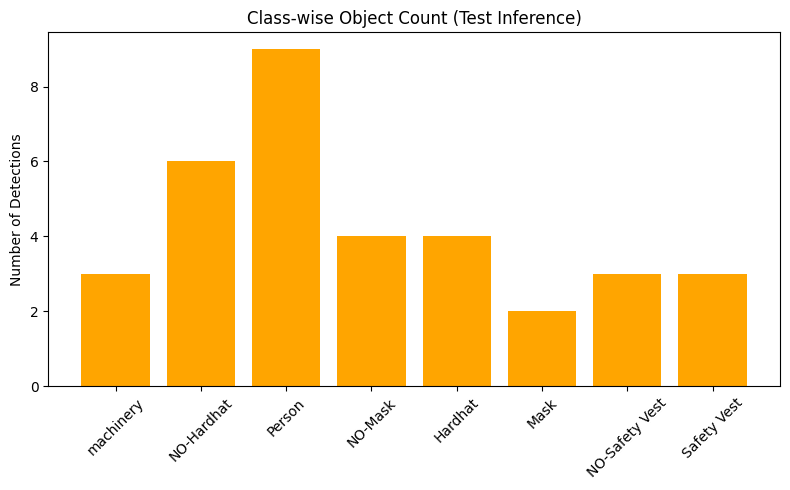

In [61]:
# Plot: Class-wise object counts
plt.figure(figsize=(8, 5))
plt.bar(class_counter.keys(), class_counter.values(), color='orange')
plt.title("Class-wise Object Count (Test Inference)")
plt.ylabel("Number of Detections")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

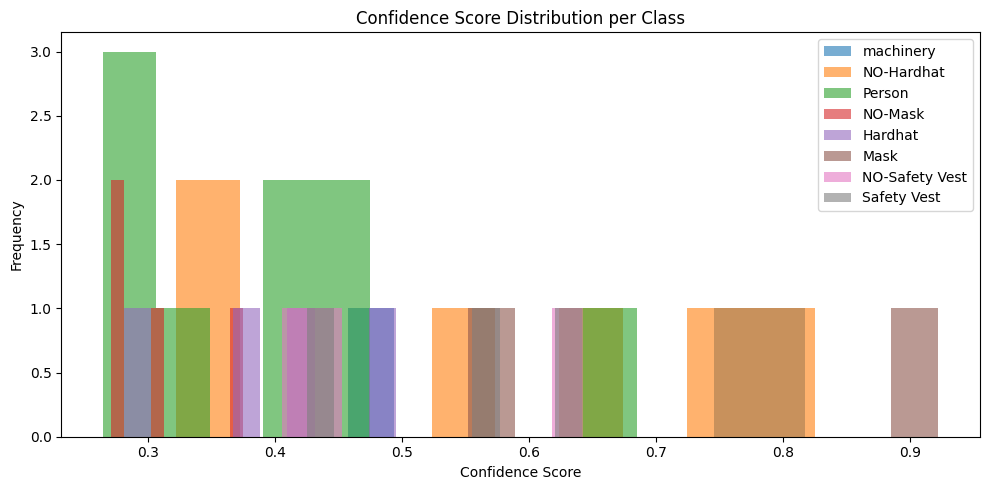

In [62]:
# Plot: Confidence Score Histogram
plt.figure(figsize=(10, 5))
for cls, scores in confidence_scores.items():
    plt.hist(scores, bins=10, alpha=0.6, label=cls)

plt.title("Confidence Score Distribution per Class")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('/kaggle/working/yolo_dataset/construction_site_safety_detection_model2/weights/best.pt')

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


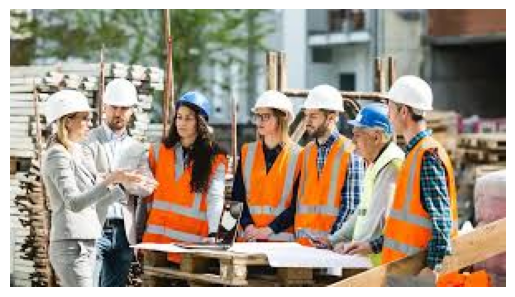

In [85]:
image_path = '/images-2.jpeg'

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



image 1/1 /images-2.jpeg: 384x640 6 Hardhats, 1 NO-Mask, 2 Persons, 2 Safety Vests, 11.8ms
Speed: 3.5ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Classes detected: [0.0, 0.0, 0.0, 7.0, 0.0, 5.0, 5.0, 0.0, 3.0, 0.0, 7.0]
Confidences: [0.735183835029602, 0.6833885312080383, 0.6335887312889099, 0.5352301001548767, 0.35444527864456177, 0.33339545130729675, 0.32901981472969055, 0.2968912720680237, 0.27404505014419556, 0.2592809200286865, 0.25360655784606934]
Bounding boxes: [[227.50784301757812, 39.36997604370117, 256.0357360839844, 62.89590835571289], [145.522705078125, 47.539310455322266, 176.3719940185547, 67.06108856201172], [209.8155975341797, 54.65987014770508, 231.2915802001953, 74.03013610839844], [215.50936889648438, 79.94410705566406, 269.603759765625, 156.30845642089844], [99.05746459960938, 46.35576629638672, 118.66070556640625, 62.7830696105957], [203.1846923828125, 54.174766540527344, 279.5846252441406, 167.33621215820312], [131.83979

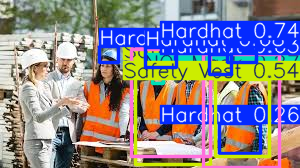

In [86]:
results = model.predict(image_path, imgsz=640, conf=0.25)
result = results[0]  # first image's results
print("Classes detected:", result.boxes.cls.tolist())       # e.g. [8]
print("Confidences:", result.boxes.conf.tolist())           # e.g. [0.33]
print("Bounding boxes:", result.boxes.xyxy.tolist())        # bounding box coordinates
print("Class names:", result.names)                         # maps class ID to name
result.show()